In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import gudhi as gd
from gudhi.wasserstein import wasserstein_distance
from gudhi import bottleneck_distance

def analyze_persistence_series(price_series, policy_data, policy_columns, 
                                lag_dim=5, window_size=30, max_edge_length=50.0, verbose=True):
    import numpy as np
    import pandas as pd
    import gudhi as gd
    from tqdm import tqdm

    # Ensure price_series is a pandas Series
    if isinstance(price_series, np.ndarray):
        price_series = pd.Series(price_series)

    # Construct lagged price series for embedding
    price_lags = np.vstack([
        price_series[i:-(lag_dim + 1 - i)] for i in range(1, lag_dim + 1)
    ]).T

    # Align current price values with lagged data
    price_current = price_series[lag_dim:].reset_index(drop=True)[:len(price_lags)].values.reshape(-1, 1)

    # Select and align relevant policy variables
    policy_used = policy_data[policy_columns]
    policy_current = policy_used.iloc[lag_dim:lag_dim + len(price_lags)].reset_index(drop=True)

    # Combine price, lagged series, and policy data into one point cloud
    cloud = np.hstack([price_current, price_lags, policy_current.values])
    dates = policy_data["Date"].iloc[lag_dim:lag_dim + len(price_lags)].reset_index(drop=True)

    # Compute persistent homology norms (L1) for H1 features
    def compute_persistence_norms(cloud_slice):
        rips = gd.RipsComplex(points=cloud_slice, max_edge_length=max_edge_length)
        st = rips.create_simplex_tree(max_dimension=2)
        persistence = st.persistence()
        h1_l1 = h1_l2 = h0_l1 = h0_l2 = 0
        for dim, (birth, death) in persistence:
            if not np.isfinite(death): 
                continue
            life = death - birth
            if dim == 1:  # focus on 1-dimensional features (loops)
                h1_l1 += life
                h1_l2 += life ** 2
            elif dim == 0:
                h0_l1 += life
                h0_l2 += life ** 2
        return {
            "H1_L1": h1_l1,
            "H1_L2": np.sqrt(h1_l2),
            # H0 metrics commented out (not used in this analysis)
        }

    # Extract H1 persistence diagram for each window
    def get_h1_diagram(cloud_slice):
        rips = gd.RipsComplex(points=cloud_slice, max_edge_length=max_edge_length)
        st = rips.create_simplex_tree(max_dimension=2)
        diag = st.persistence()
        return np.array([pair[1] for pair in diag if pair[0] == 1 and np.isfinite(pair[1][1])])

    # Slide window across time series to compute norms and diagrams
    norms, diagrams = [], []
    iterator = tqdm(range(len(cloud) - window_size)) if verbose else range(len(cloud) - window_size)
    for i in iterator:
        subcloud = cloud[i:i+window_size]
        norms.append(compute_persistence_norms(subcloud))
        diagrams.append(get_h1_diagram(subcloud))

    return pd.DataFrame(norms), diagrams, dates[window_size:]


100%|███████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 606.02it/s]


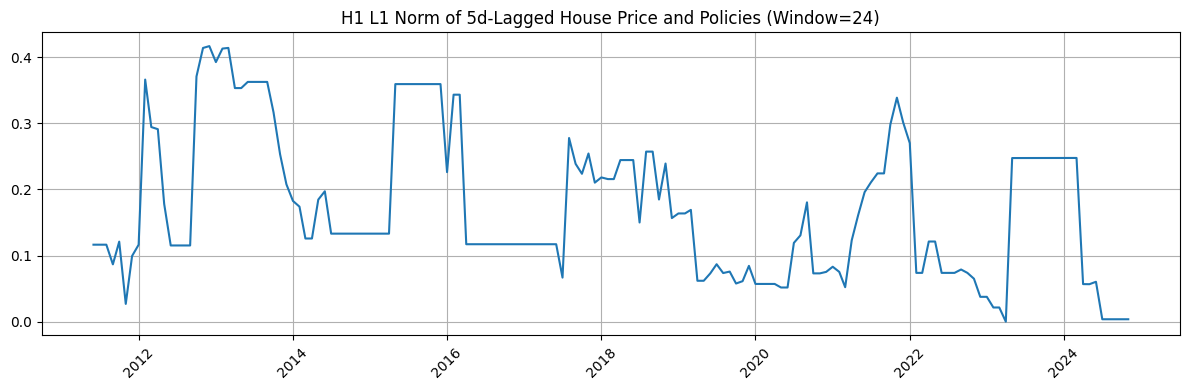

In [2]:
df = pd.read_csv("London_Housing_Policy_Dataset_sd.csv", parse_dates=["Date"])
price_series = df["Average_Housing_Price"].values
policy_columns = ['Weekly_Earnings','Employment_Rate','Benefit Caseload','Housing Supply','Euro Rate','Interest Rate']
lag_dim=5
window_size=24

norm_df, diagrams, aligned_dates = analyze_persistence_series(
    price_series=price_series,
    policy_data=df,
    policy_columns=policy_columns,
    lag_dim=lag_dim,
    window_size=window_size,
    verbose=True
)


plt.figure(figsize=(12, 4))
plt.plot(aligned_dates, norm_df["H1_L1"])
plt.title("H1 L1 Norm of 5d-Lagged House Price and Policies (Window=24)")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


In [4]:
norm_df.describe()

,H1_L1,H1_L2
count,162.000000,162.000000
mean,0.173129,0.127651
std,0.109668,0.077149
min,0.000000,0.000000
25%,0.079956,0.056864
50%,0.133144,0.118985
75%,0.247477,0.188866
max,0.416770,0.264814


In [3]:
norm_df['H1_L1'].to_csv('norm-LD.csv')

In [6]:
df1

,Unnamed: 0,H1_L1
0,0,0.116445
1,1,0.116445
2,2,0.116445
3,3,0.086714
4,4,0.121073
...,...,...
157,157,0.003655
158,158,0.003655
159,159,0.003655
160,160,0.003655


In [8]:
# Paired sample t-test
import pandas as pd
from scipy.stats import ttest_rel

df1 = pd.read_csv("norm-LD.csv")
df2 = pd.read_csv("norm-NW.csv")
ld_values = df1["H1_L1"]
nw_values = df2["H1_L1"]

t_stat, p_val = ttest_rel(ld_values, nw_values)

print(f"t-value: {t_stat:.4f}")
print(f"p-value: {p_val:.5f}")

t-value: -2.2887
p-value: 0.02340


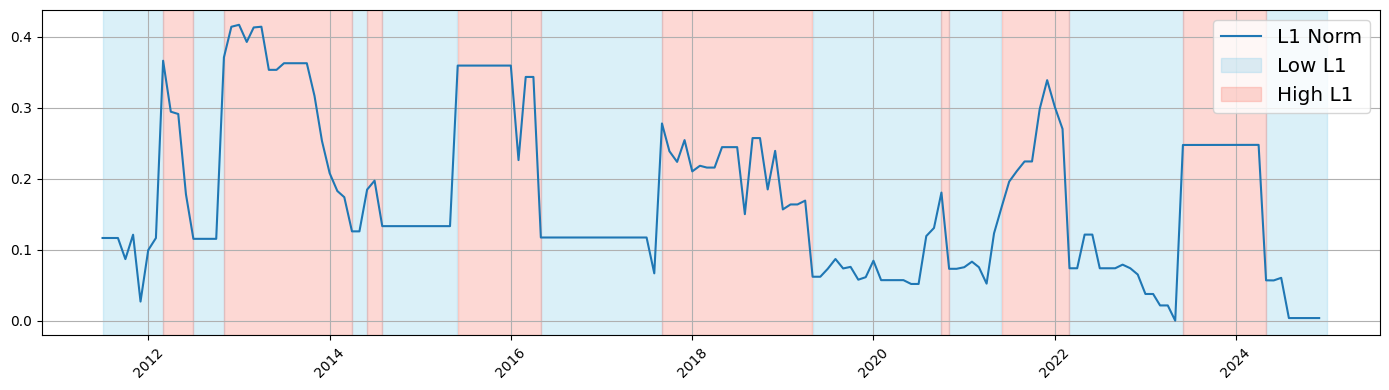

In [5]:
# Figure 4.2 L₁ Norm of full multivariate embedding point cloud and High/Low L₁ Norm Periods (London) 
import matplotlib.pyplot as plt
import pandas as pd

# Load persistence norms and align with date column
norm = pd.read_csv("norm-LD.csv", parse_dates=["Date"])
norm_df["Date"] = norm["Date"]

# Define manually selected high and low L1 norm periods
high_periods_filtered = [
    ("2012-03-01", "2012-06-30"),
    ("2012-11-01", "2014-03-31"),
    ("2014-06-01", "2014-07-31"),
    ("2015-06-01", "2016-04-30"),
    ("2017-09-01", "2019-04-30"),
    ("2020-10-01", "2020-10-31"),
    ("2021-06-01", "2022-02-28"),
    ("2023-06-01", "2024-04-30")
]

low_periods_filtered = [
    ("2011-07-01", "2012-02-29"),
    ("2012-07-01", "2012-10-31"),
    ("2014-04-01", "2014-05-31"),
    ("2014-08-01", "2015-05-31"),
    ("2016-05-01", "2017-08-31"),
    ("2019-05-01", "2020-09-30"),
    ("2020-11-01", "2021-05-31"),
    ("2022-03-01", "2023-05-31"),
    ("2024-05-01", "2024-12-31")
]

# Plot L1 norm time series
plt.figure(figsize=(14, 4))
plt.plot(norm_df["Date"], norm_df["H1_L1"], label="L1 Norm")

# Highlight low periods with shaded regions
for start, end in low_periods_filtered:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), 
                color='skyblue', alpha=0.3, label="Low L1")

# Highlight high periods with shaded regions
for start, end in high_periods_filtered:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), 
                color='salmon', alpha=0.3, label="High L1")

# Remove duplicate legend labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize='x-large')

# Format axis for readability
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


In [24]:
norm_df.to_csv('2.csv')